In [8]:
from outputs import SYZParameter
import matplotlib.pyplot as plt
import numpy as np

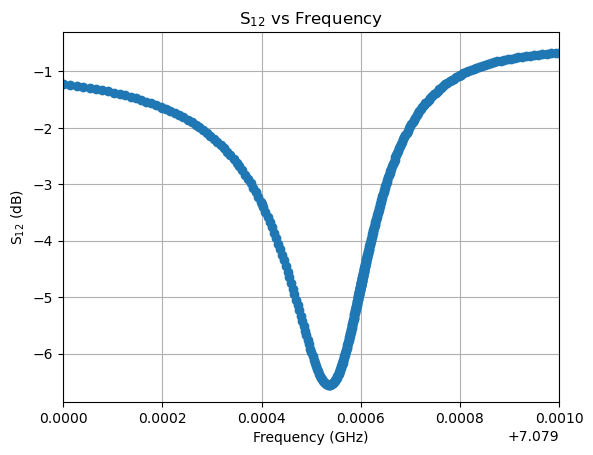

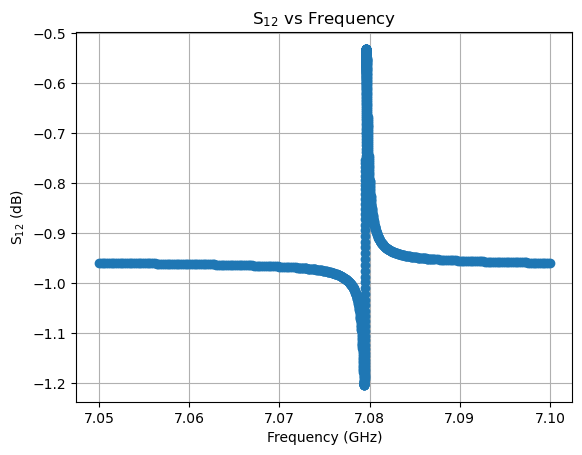

In [24]:
# read in the Touchstone file you just generated
sp = SYZParameter.from_touchstone(r"C:\Users\slab-mchalk\Desktop\cqed-design-ai\fitting\cpw.s2p")
# :contentReference[oaicite:1]{index=1}

# frequencies (GHz) and the 2×2 S-matrix (complex) array
f = sp.f                       # shape (N,) in GHz
S = sp.value                   # shape (N, 2, 2)

# pick out S12 = measurement at port 1 due to excitation at port 2
s12 = S[:, 0, 1]

# plot magnitude in dB
plt.figure()
plt.plot(f, 20*np.log10(np.abs(s12)), marker='o')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S$_{12}$ (dB)')
plt.title('S$_{12}$ vs Frequency')
plt.grid(True)
plt.xlim(7.0790, 7.08)
plt.show()

plt.plot(f, (np.angle(s12)), marker='o')
plt.xlabel('Frequency (GHz)')
plt.ylabel('S$_{12}$ (dB)')
plt.title('S$_{12}$ vs Frequency')
plt.grid(True)
plt.show()




In [27]:

# Circle fitting package

import numpy as np
import matplotlib.pyplot as plt
import lmfit

# define function
def get_params(fitresults,var,option):
    if option == 'value':
        param = fitresults.params.get(var)
        if (param is not None) and (param.value is not None):
            return param.value
        else:
            return 0.0
    elif option == 'stderr':
        param = fitresults.params.get(var)
        if (param is not None) and (param.stderr is not None):
            return param.stderr
        else:
            return 0.0

def S21_reflection(a, alpha, tau, fr, Qtot, Qc, phi, f): # assuming use of circulator

    return a*np.exp(1j*(alpha + 2*np.pi*f*tau))*(1 - 2*(Qtot/Qc)*np.exp(-1j*phi)/(1 + 2j*Qtot*(f/fr - 1)))

def S21_transmission(a, alpha, tau, fr, Qtot, Qc, phi, f):

    return a*np.exp(1j*(alpha + 2*np.pi*f*tau))*2*(Qtot/Qc)*np.exp(-1j*phi)/(1 + 2j*Qtot*(f/fr - 1))

def S21_transmission_fano(a, alpha, tau, fr, Qtot, Qc, phi, xoff, yoff, f):

    return (S21_transmission(a, alpha, tau, fr, Qtot, Qc, phi, f) + xoff + 1j*yoff)

def S21_hanger(a, alpha, tau, fr, Qtot, Qc, phi, f):

    return a*np.exp(1j*(alpha + 2*np.pi*f*tau))*(1 - (Qtot/Qc)*np.exp(-1j*phi)/(1 + 2j*Qtot*(f/fr - 1)))

def circlefit(freqs, Xn, Yn, fittype = 'hanger', plotlabel = '', fitQscl = 5.0, show_plots = True, plot_detail = False, circle_plot_limits = None, print_results = True, amp_cal_transmission = 1, fano = False):
    
    tempdict = {}
    
    if print_results:
        print('Using circle fit to get initial fit parameters.')
        print('Fitting type = '+fittype)
    
    def circle_fitresidual(params, Idata, Qdata):

        xc = params['xc']
        yc = params['yc']
        rc = params['rc']

        return (Idata - xc)**2 + (Qdata - yc)**2 - rc**2
    
    # guess parameters for circle

    idx_max_guess = np.where(Xn == max(Xn))
    idx_min_guess = np.where(Xn == min(Xn))

    if idx_max_guess[0].shape[0] != 1: # assert that you find exactly one index

        idx_max_guess = 0 # optimized for reflection / hanger (transmission dip)
        idx_min_guess = int(Xn.shape[0]/2) # optimized for reflection / hanger (transmission dip)

    za_guess = Xn[idx_max_guess] + 1j*Yn[idx_max_guess] # max of circle along real axis
    zb_guess = Xn[idx_min_guess] + 1j*Yn[idx_min_guess] # min of circle along real axis
    zc_guess = za_guess + 0.5*(zb_guess - za_guess) # center of circle
        
    rc_guess = 0.5*np.abs(za_guess - zb_guess)
    xc_guess = np.real(zc_guess)
    yc_guess = np.imag(zc_guess)

    # plot guess circle

    xx = np.linspace(-np.pi, np.pi, 501)
    Xg = xc_guess + rc_guess*np.cos(xx)
    Yg = yc_guess + rc_guess*np.sin(xx)
        
    # set fit parameters

    params = lmfit.Parameters()    
    params.add('xc', xc_guess, vary = True)
    params.add('yc', yc_guess, vary = True)
    params.add('rc', rc_guess, min = 0.0, vary = True)        
    
    # perform fitting

    fitresults = lmfit.minimize(circle_fitresidual, params, args = (Xn, Yn))

    if print_results:
        print(fitresults)
   
    # get fit result

    #xc_fit = fitresults.params.get('xc').value if not None else 0.0
    #xc_fit_stderr = fitresults.params.get('xc').stderr if not None else 0.0
    #yc_fit = fitresults.params.get('yc').value if not None else 0.0
    #yc_fit_stderr = fitresults.params.get('yc').stderr if not None else 0.0
    #rc_fit = fitresults.params.get('rc').value if not None else 0.0
    #rc_fit_stderr = fitresults.params.get('rc').stderr if not None else 0.0

    xc_fit = get_params(fitresults,'xc','value')
    xc_fit_stderr = get_params(fitresults,'xc','stderr')
    yc_fit = get_params(fitresults,'yc','value')
    yc_fit_stderr = get_params(fitresults,'yc','stderr')
    rc_fit = get_params(fitresults,'rc','value')
    rc_fit_stderr = get_params(fitresults,'rc','stderr')

    # plot fit

    Xfit = xc_fit + rc_fit*np.cos(xx)
    Yfit = yc_fit + rc_fit*np.sin(xx) 
    
    # store fit values in dictionary

    tempdict['xc'] = xc_fit
    tempdict['xc_stderr'] = xc_fit_stderr    
    tempdict['yc'] = yc_fit
    tempdict['yc_stderr'] = yc_fit_stderr
    tempdict['rc'] = rc_fit
    tempdict['rc_stderr'] = rc_fit_stderr     
    
    # shifted data to get theta0

    Xs = Xn - xc_fit
    Ys = Yn - yc_fit
    theta = np.unwrap(np.angle(Xs+1j*Ys))

    # fit the phase of the shifted data to get theta0

    def phase_fitresidual(params, f, data=None, eps_data=None):

        theta0 = params['theta0']
        Qtot = params['Qtot']
        fr = params['fr']

        model = theta0 - 2*np.arctan(2*Qtot*(f/fr - 1))

        if data is None:
            return model
        if eps_data is None:
            return data - model
        return (data - model)/eps_data
    
    # guess parameters - assume that the data to be fit is roughly centered on the resonance frequency, and that the span is set to roughly 5-10x the linewidth (set by the fitQscl parameter)

    theta0c_guess  = np.mean(theta)
    Qtotc_guess = fitQscl*np.mean(freqs)/np.abs(freqs[-1] - freqs[0])
    frc_guess = np.mean(freqs)
    
    # initialize fit parameters

    phase_params = lmfit.Parameters()
    phase_params.add('theta0', theta0c_guess, vary = True)
    phase_params.add('Qtot', Qtotc_guess, vary = True)
    phase_params.add('fr', frc_guess, vary = True)
    
    # plot guess phase

    ff = np.linspace(freqs[0], freqs[-1], 501)
    theta_guess = phase_fitresidual(phase_params, ff)
        
    # perform fitting

    phase_fitresults = lmfit.minimize(phase_fitresidual, phase_params, args=(freqs, theta))

    if print_results:
        print(lmfit.fit_report(phase_fitresults))
    
    # get fit result

    #theta0c_fit = phase_fitresults.params.get('theta0').value 
    #theta0c_fit_stderr = phase_fitresults.params.get('theta0').stderr 
    #Qtotc_fit = phase_fitresults.params.get('Qtot').value 
    #Qtotc_fit_stderr = phase_fitresults.params.get('Qtot').stderr 
    #frc_fit = phase_fitresults.params.get('fr').value 
    #frc_fit_stderr = phase_fitresults.params.get('fr').stderr 

    theta0c_fit = get_params(phase_fitresults,'theta0','value')
    theta0c_fit_stderr = get_params(phase_fitresults,'theta0','stderr')
    Qtotc_fit = get_params(phase_fitresults,'Qtot','value')
    Qtotc_fit_stderr = get_params(phase_fitresults,'Qtot','stderr')
    frc_fit = get_params(phase_fitresults,'fr','value')
    frc_fit_stderr = get_params(phase_fitresults,'fr','stderr')
    # plot fit

    theta_fit = phase_fitresidual(phase_fitresults.params, ff)

    # store them in dictionary

    tempdict['theta0'] = theta0c_fit
    tempdict['theta0_stderr'] = theta0c_fit_stderr
    tempdict['Qtot'] = Qtotc_fit
    tempdict['Qtot_stderr'] = Qtotc_fit_stderr  
    tempdict['fr'] = frc_fit
    tempdict['fr_stderr'] = frc_fit_stderr
    
    # calculate and plot on & off resonance point in shifted data

    beta = theta0c_fit + np.pi 
    beta_stderr = theta0c_fit_stderr 

    #print(beta,rc_fit_stderr,theta0c_fit_stderr)
    xoffrs = rc_fit*np.cos(beta)
    xoffrs_stderr = np.sqrt((np.cos(beta)*rc_fit_stderr)**2 + (rc_fit*np.sin(beta)*beta_stderr)**2)
    yoffrs = rc_fit*np.sin(beta)
    yoffrs_stderr = np.sqrt((np.sin(beta)*rc_fit_stderr)**2 + (rc_fit*np.cos(beta)*beta_stderr)**2)
    xonrs = -rc_fit*np.cos(beta)
    #xonrs_stderr = np.sqrt((np.cos(beta)*rc_fit_stderr)**2 + (rc_fit*np.sin(beta)*beta_stderr)**2)
    yonrs = -rc_fit*np.sin(beta)
    #yonrs_stderr = np.sqrt((np.sin(beta)*rc_fit_stderr)**2 + (rc_fit*np.cos(beta)*beta_stderr)**2)
            
    # calculate and plot on & off resonance point in raw data   
    xoffr = xc_fit + xoffrs
    xoffr_stderr = np.sqrt((xc_fit_stderr)**2 + (xoffrs_stderr)**2)
    yoffr = yc_fit + yoffrs
    yoffr_stderr = np.sqrt((yc_fit_stderr)**2 + (yoffrs_stderr)**2)
    doffr = np.sqrt(xoffr**2+yoffr**2)
    doffr_stderr = np.sqrt((xoffr*xoffr_stderr/doffr)**2 + (yoffr*yoffr_stderr/doffr)**2)
    xonr = xc_fit + xonrs
    #xonr_stderr = np.sqrt((xc_fit_stderr)**2 + (xonrs_stderr)**2)
    yonr = yc_fit + yonrs
    #yonr_stderr = np.sqrt((yc_fit_stderr)**2 + (yonrs_stderr)**2)
    
    # rotate alpha

    alphac_fit = np.angle(xoffr + 1j*yoffr)
    alphac_fit_stderr = np.sqrt((yoffr_stderr/xoffr)**2+(yoffr*xoffr_stderr/xoffr/xoffr)**2)/(1+(yoffr/xoffr)**2)
    tempdict['alpha'] = alphac_fit 
    tempdict['alpha_stderr'] = alphac_fit_stderr     
    Xr1 = Xn*np.cos(alphac_fit) + Yn*np.sin(alphac_fit)
    Yr1 = Yn*np.cos(alphac_fit) - Xn*np.sin(alphac_fit)   
    xoffr1 = xoffr*np.cos(alphac_fit) + yoffr*np.sin(alphac_fit)
    yoffr1 = yoffr*np.cos(alphac_fit) - xoffr*np.sin(alphac_fit) 
    xonr1 = xonr*np.cos(alphac_fit) + yonr*np.sin(alphac_fit)
    yonr1 = yonr*np.cos(alphac_fit) - xonr*np.sin(alphac_fit)
    
    # calculate ac - the parameter that determines how to scale the original data from the origin

    ac_fit = doffr
    ac_fit_stderr = doffr_stderr
    tempdict['a'] = ac_fit 
    tempdict['a_stderr'] = ac_fit_stderr 
                
    # shift to origin to get phi

    Xs1 = Xr1 - xoffr1
    Ys1 = Yr1 - yoffr1
    xoffr1s = 0.0
    yoffr1s = 0.0
    
    xonr1s = -2*rc_fit*np.cos(beta - alphac_fit)
    xonr1s_stderr = 2.0*np.sqrt((np.cos(beta-alphac_fit)*rc_fit_stderr)**2
                                +(rc_fit*np.sin(beta-alphac_fit)*beta_stderr)**2
                                +(rc_fit*np.sin(beta-alphac_fit)*alphac_fit_stderr)**2)

    yonr1s = -2*rc_fit*np.sin(beta - alphac_fit)
    yonr1s_stderr = 2.0*np.sqrt((np.sin(beta-alphac_fit)*rc_fit_stderr)**2
                                +(rc_fit*np.cos(beta-alphac_fit)*beta_stderr)**2
                                +(rc_fit*np.cos(beta-alphac_fit)*alphac_fit_stderr)**2)
    
    phic_fit = np.pi - np.angle(xonr1s + 1j*yonr1s)
    phic_fit_stderr = np.sqrt((yonr1s_stderr/xonr1s)**2+(yonr1s*xonr1s_stderr/xonr1s/xonr1s)**2)/(1+(yonr1s/xonr1s)**2)
    
    tempdict['phi'] = phic_fit
    tempdict['phi_stderr'] = phic_fit_stderr
    
    if fittype == 'hanger':
        Qcc_fit = Qtotc_fit*ac_fit/(2*rc_fit)
        Qcc_fit_stderr = np.sqrt((Qcc_fit/ac_fit*ac_fit_stderr)**2+(Qcc_fit/rc_fit*rc_fit_stderr)**2+(Qcc_fit/Qtotc_fit*Qtotc_fit_stderr)**2)
        
    if fittype == 'reflection':
        Qcc_fit = ac_fit/rc_fit*Qtotc_fit
        Qcc_fit_stderr = np.sqrt((Qcc_fit/ac_fit*ac_fit_stderr)**2+(Qcc_fit/rc_fit*rc_fit_stderr)**2+(Qcc_fit/Qtotc_fit*Qtotc_fit_stderr)**2)   
        
    if fittype == 'transmission':

        #print('Warning: Requires amplitude calibration - otherwise, ignore internal & coupling Q split.')

        Qcc_fit = amp_cal_transmission/rc_fit*Qtotc_fit
        Qcc_fit_stderr = np.sqrt((Qcc_fit/ac_fit*ac_fit_stderr)**2+(Qcc_fit/rc_fit*rc_fit_stderr)**2+(Qcc_fit/Qtotc_fit*Qtotc_fit_stderr)**2)
    
    tempdict['Qc'] = Qcc_fit
    tempdict['Qc_stderr'] = Qcc_fit_stderr

    if print_results:
        print('Qc = '+str(Qcc_fit)+' +- '+str(Qcc_fit_stderr))
    
    def circle_offset_fitresidual(params, Idata, Qdata):

        xc = params['x_off']
        yc = params['y_off']

        return (Idata - xc)**2 + (Qdata - yc)**2
    
    # include extra rotation due to fano interference

    if fano:
        xoff_guess = 0.01
        yoff_guess = -0.01

        # set fit parameters

        offset_params = lmfit.Parameters()    
        offset_params.add('x_off', xoff_guess, vary = True)
        offset_params.add('y_off', yoff_guess, vary = True)   
        
        cfitdata = S21_transmission(tempdict['a'], tempdict['alpha'], 0, tempdict['fr'], tempdict['Qtot'], tempdict['Qc'], tempdict['phi'], freqs)

        # perform fitting

        offset_fitresults = lmfit.minimize(circle_offset_fitresidual, offset_params, args = (Xn - np.real(cfitdata), Yn - np.imag(cfitdata)))

        if print_results:
            print(lmfit.fit_report(offset_fitresults))
        tempdict['x_off'] = offset_fitresults.params['x_off']
        tempdict['y_off'] = offset_fitresults.params['y_off']

    QicInv_fit = 1/Qtotc_fit - np.cos(phic_fit)/Qcc_fit
    QicInv_fit_stderr = np.sqrt((Qtotc_fit_stderr/Qtotc_fit/Qtotc_fit)**2
                                +(phic_fit_stderr*np.sin(phic_fit)/Qcc_fit)**2
                                +(Qcc_fit_stderr*np.cos(phic_fit)/Qcc_fit/Qcc_fit)**2)
    
    Qic_fit = 1/QicInv_fit
    Qic_fit_stderr = QicInv_fit_stderr*Qic_fit**2
    
    tempdict['Qi'] = Qic_fit
    tempdict['Qi_stderr'] = Qic_fit_stderr 
    
    # print phase fit results
    if print_results:
        print('\ncircle fit results:')
        print('xc = %6.3e +- %6.3e' %(xc_fit, xc_fit_stderr))
        print('yc = %6.3e +- %6.3e' %(yc_fit, yc_fit_stderr))
        print('rc = %6.3e +- %6.3e' %(rc_fit, rc_fit_stderr))  
        print('\ntheta fit results:')
        print('theta0 = %6.3e +- %6.3e' %(theta0c_fit, theta0c_fit_stderr))
        print('Qtot   = %6.3e +- %6.3e' %(Qtotc_fit, Qtotc_fit_stderr))
        print('fr     = %6.9e +- %6.3e' %(frc_fit, frc_fit_stderr))    
        print('\nderived results:')
        print('alpha = %6.3e +- %6.3e' %(alphac_fit, alphac_fit_stderr))
        print('    a = %6.3e +- %6.3e' %(ac_fit, ac_fit_stderr))
        print('   Qc = %6.3e +- %6.3e' %(Qcc_fit, Qcc_fit_stderr))
        print('  phi = %6.3e +- %6.3e' %(phic_fit, phic_fit_stderr))
        print('   Qi = %6.3e +- %6.3e' %(Qic_fit, Qic_fit_stderr))
        
    if show_plots:
        
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = [12, 8])
        
        axes[0,0].set_xlabel('I')
        axes[0,0].set_ylabel('Q')
        axes[0,0].plot(Xn, Yn, 'k.', alpha = 0.5, label = 'raw data')            

        axes[0,0].plot(Xfit, Yfit, 'r-', linewidth = 1.0, markersize = 2.0, alpha = 0.5,label = 'fit')
        
        axes[0,0].axvline(x=0, color='k', linewidth = 0.5)
        axes[0,0].axhline(y=0, color='k', linewidth = 0.5)
        axes[0,0].set_aspect('equal')
        axes[0,0].grid('on')

        if plot_detail: # plot all the different circles

            axes[0,0].plot(Xg, Yg, 'g-', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'guess circle')
            axes[0,0].plot(Xs, Ys, 'b.', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'shifted circle')

            axes[0,0].plot(xoffrs, yoffrs, 'bx', linewidth = 4.0, markersize = 8.0, alpha = 1.0) #, label = 'off resonance point shifted data')
            axes[0,0].plot(xonrs, yonrs, 'bo', linewidth = 4.0, markersize = 8.0, alpha = 1.0) #, label = 'on resonance point shifted data')

            axes[0,0].plot(xoffr, yoffr, 'kx', linewidth = 4.0, markersize = 8.0, alpha = 1.0) #, label = 'off resonance point data')
            axes[0,0].plot(xonr, yonr, 'ko', linewidth = 4.0, markersize = 8.0, alpha = 1.0), #, label = 'on resonance point data')

            axes[0,0].plot(Xr1, Yr1, 'm.', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'alpha rotated data')
            axes[0,0].plot(xoffr1, yoffr1, 'mx', linewidth = 4.0, markersize = 8.0, alpha = 1.0)
            axes[0,0].plot(xonr1, yonr1, 'mo', linewidth = 4.0, markersize = 8.0, alpha = 1.0)

            axes[0,0].plot(Xs1, Ys1, 'c.', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'alpha rotated shifted data')
            axes[0,0].plot(xoffr1s, yoffr1s, 'cx', linewidth = 4.0, markersize = 8.0, alpha = 1.0)
            axes[0,0].plot(xonr1s, yonr1s, 'co', linewidth = 4.0, markersize = 8.0, alpha = 1.0)

        axes[0,0].legend(loc = 'best')

        if circle_plot_limits: # zoom in on a specific region in IQ space to inspect manually

            axes[0,0].set_xlim([circle_plot_limits[0], circle_plot_limits[1]])
            axes[0,0].set_ylim([circle_plot_limits[2], circle_plot_limits[3]])

        axes[0,1].set_title('phase of shifted data')
        axes[0,1].set_xlabel('freq')
        axes[0,1].set_ylabel('phase (rad)')
        axes[0,1].grid('on')

        # plot the phase of the shifted data

        axes[0,1].plot(freqs, theta, 'b.', linewidth = 1.0, markersize = 2.0, alpha = 0.5)
        axes[0,1].plot(ff, theta_fit, 'r-', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'fit')

        if plot_detail:

            axes[0,1].plot(ff, theta_guess, 'g-', linewidth = 1.0, markersize = 2.0, alpha = 0.5, label = 'guess phase')

        axes[0,1].legend(loc = 'best')

        axes[1,0].set_title('circle fit residual')
        axes[1,0].set_xlabel('freq (Hz)')
        axes[1,0].set_ylabel(r'$\Delta r^2$')

        axes[1,0].plot(freqs, fitresults.residual, '-', linewidth = 1.0, markersize = 2.0, alpha = 0.8, label = 'residuals')
        axes[1,0].grid('on');

        axes[1,1].set_title('phase fit residual')
        axes[1,1].set_xlabel('freq (Hz)')
        axes[1,1].set_ylabel(r'$\Delta \theta$')

        axes[1,1].plot(freqs, phase_fitresults.residual, '-', linewidth = 1.0, markersize = 2.0, alpha = 0.8, label = 'residuals')
        axes[1,1].grid('on');

        plt.tight_layout();
    
    return tempdict

Using circle fit to get initial fit parameters.
Fitting type = transmission
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 848
    # variables        = 3
    chi-square         = 0.05429492
    reduced chi-square = 6.4254e-05
    Akaike info crit   = -8182.46200
    Bayesian info crit = -8168.23336
[[Variables]]
    theta0: -4.38144484 +/- 3.4837e-04 (0.01%) (init = -4.361894)
    Qtot:    24033.0039 +/- 15.4337272 (0.06%) (init = 707.8238)
    fr:      7.0796e+09 +/- 54.2390860 (0.00%) (init = 7.078238e+09)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta0, fr) = -0.5885
    C(Qtot, fr)   = +0.3696
Qc = 104049.45943460228 +- 67.6693701082243

circle fit results:
xc = 4.539e-01 +- 3.643e-05
yc = -5.347e-01 +- 2.034e-05
rc = 2.310e-01 +- 1.883e-05

theta fit results:
theta0 = -4.381e+00 +- 3.484e-04
Qtot   = 2.403e+04 +- 1.543e+01
fr     = 7.079564243e+09 +- 5.424e+01

derived results:
alpha = -9.585e-01 +- 7.88

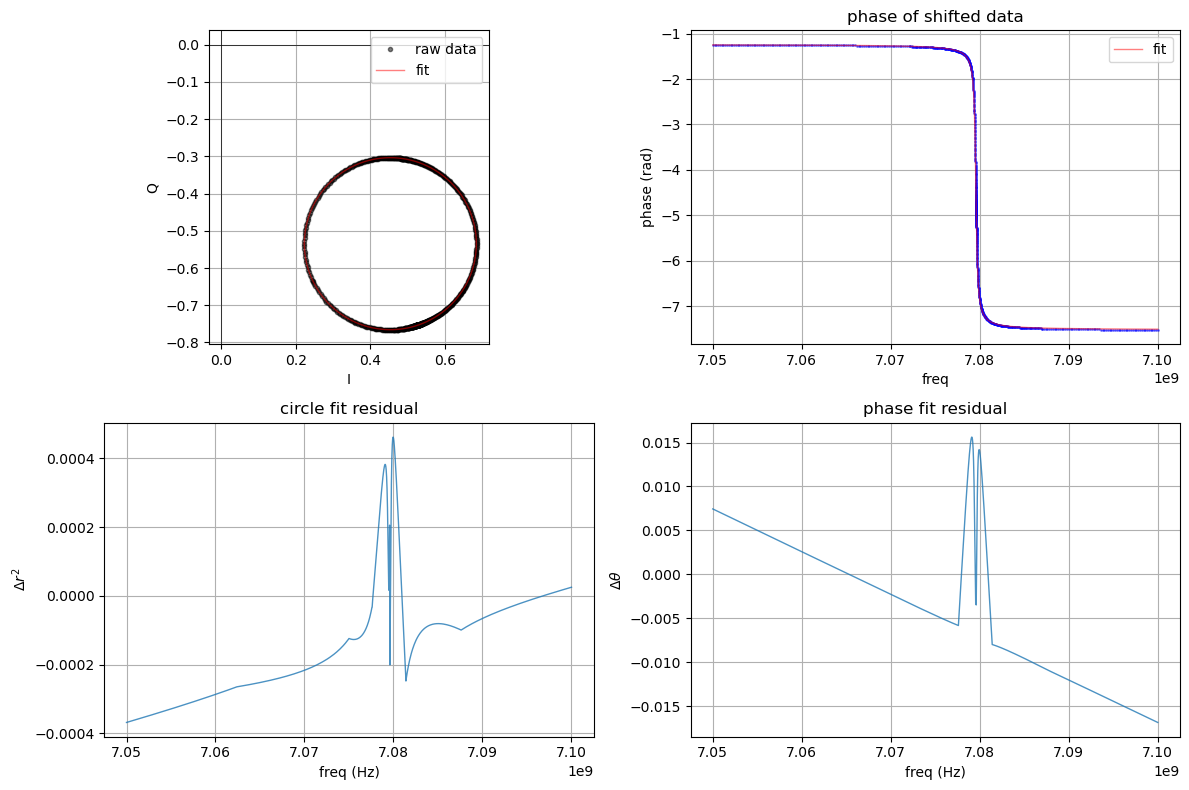

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
#import circlefit  # assuming the code you shared is saved as circlefit.py

# Load the S2P data
network = rf.Network(r"C:\Users\slab-mchalk\Desktop\cqed-design-ai\fitting\cpw.s2p")

# Extract frequency and S21 data
freqs = network.f  # Frequency in Hz
s21 = network.s[:, 1, 0]  # S21 parameter (assuming 2-port, 0-indexed)

# Separate real and imaginary parts
real_data = s21.real
imag_data = s21.imag

# Run the circle fit
fitresults = circlefit(
    freqs=freqs,
    Xn=real_data, 
    Yn=imag_data,
    fittype='transmission',  # Change to 'hanger' or 'reflection' if needed based on your CPW design
    plotlabel='CPW Resonator',
    show_plots=True,
    print_results=True
)

# Print out key resonator parameters
print("\nSummary of Key Parameters:")
print(f"Resonance Frequency: {fitresults['fr']/1e9:.6f} GHz")
print(f"Loaded Quality Factor (Q_L): {fitresults['Qtot']:.0f}")
print(f"Coupling Quality Factor (Q_c): {fitresults['Qc']:.0f}")
print(f"Internal Quality Factor (Q_i): {fitresults['Qi']:.0f}")

# You can also save the fit results to a file
np.save('cpw_fitresults.npy', fitresults)